In [1]:
# This notebook will use mangoct CLI tools (mgfpj.exe and mgfbp.exe) to do forward projection and FBP reconstruction.
# Tools can be downloaded at https://github.com/SEU-CT-Recon/mandoct/tree/master/out/build/x64-Release.
# Note that currently the Taichi-based mangoct (https://github.com/SEU-CT-Recon/Reconstruction_program_taichi)
# has replaced the CLI tools in our group, so that this tutorial might be somehow outdated.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import os
from os.path import abspath
from crip.io import imreadRaw, imwriteRaw
from crip.mangoct import MgfbpCliConfig, MgfpjCliConfig, MgCliFbp, MgCliFpj
from crip.shared import shepplogan
from crip.plot import window, VMIN0_VMAX1
from crip.metric import computeRMSE
from crip.lowdose import injectPoissonNoise

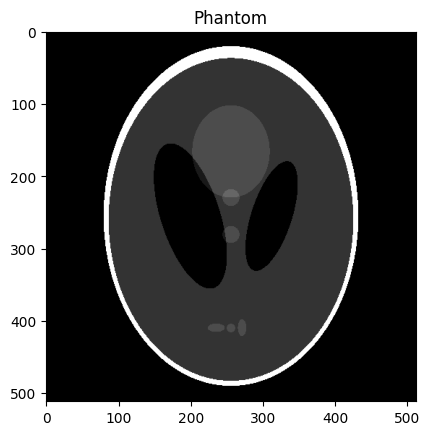

In [3]:
# Get a phantom.
phantom = shepplogan(512)
plt.figure()
plt.imshow(phantom, cmap='gray'); plt.title('Phantom')
plt.show()

In [4]:
# Prepare directories that mangoct needs to run.
os.makedirs('./tmp/img', exist_ok=True) # store images
os.makedirs('./tmp/sgm', exist_ok=True) # store sinograms
os.makedirs('./tmp/rec', exist_ok=True) # store reconstructions
imwriteRaw(phantom, './tmp/img/img_shepplogan.raw', dtype=np.float32)

In [5]:
# Forward projection.
fpjCfg = MgfpjCliConfig()
fpjCfg.setIO(abspath('./tmp/img'), abspath('./tmp/sgm'), 'img.*', OutputFileReplace=['img', 'sgm'])
fpjCfg.setGeometry(100, 200, 0, 360) # it's important that both crip and mangoct uses [mm] as default length unit
fpjCfg.setSgmFanBeam(360, 1000, 0.25) # detector pitch 0.25 mm
fpjCfg.setRecFanBeam(512, 0.2) # image pixel size 0.2 mm

MgCliFpj(tempDir='./tmp').exec(fpjCfg) # assumes mgfbp.exe is accessible in PATH and CUDA Device 0 is used

Loading config D:\MedRecon\crip\example\tmp\crip_mangoct__4azh51s.mgfpj.jsonc...

--FULL scan--

    

Forward projection img_shepplogan.raw ...

Processing slice#   1/  1

->	Saved to file sgm_shepplogan.raw

Total cost: 488.965118 ms



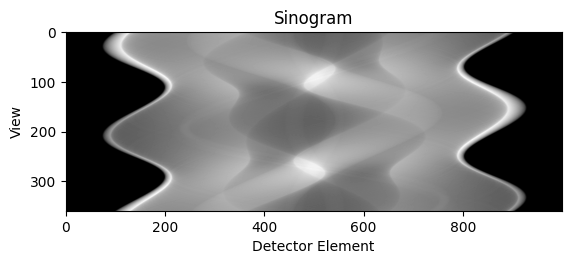

In [6]:
# Show the sinogram.
sgm = imreadRaw('./tmp/sgm/sgm_shepplogan.raw', 360, 1000, nSlice=1, dtype=np.float32).squeeze()
plt.figure()
plt.imshow(sgm, cmap='gray'); plt.title('Sinogram'); plt.xlabel('Detector Element'); plt.ylabel('View')
plt.show()

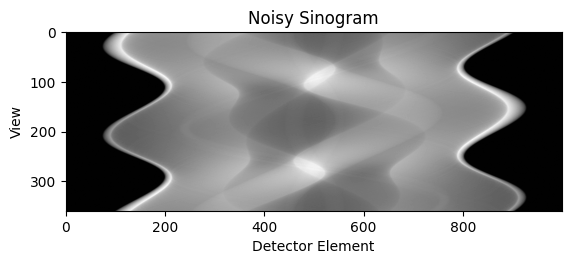

In [7]:
# Add some noise for simulation.
noisySgm = injectPoissonNoise(sgm, 'postlog', 1e5)
imwriteRaw(noisySgm, './tmp/sgm/sgm_noisy.raw')
plt.figure()
plt.imshow(noisySgm, cmap='gray'); plt.title('Noisy Sinogram'); plt.xlabel('Detector Element'); plt.ylabel('View')
plt.show()

In [8]:
# FBP Reconstruction.
fbpCfg = MgfbpCliConfig()
fbpCfg.setIO(abspath('./tmp/sgm'), abspath('./tmp/rec'), 'sgm.*', OutputFileReplace=['sgm', 'rec'])
fbpCfg.setGeometry(100, 200, 360) # [mm]
fbpCfg.setSgmFanBeam(1000, 360, 360, 0.25) # detector pitch 0.25 mm
fbpCfg.setRecFanBeam(512, 0.2, 'GaussianApodizedRamp', 0.5) # image pixel size 0.2 mm

MgCliFbp(tempDir='./tmp').exec(fbpCfg) # assumes mgfbp.exe is accessible in PATH and CUDA Device 0 is used

Loading config D:\MedRecon\crip\example\tmp\crip_mangoct_eq196z77.mgfbp.jsonc...

--FAN beam--

--FULL scan--

    Reconstructing sgm_noisy.raw ... slice#   1/  1

->	Saved to file rec_noisy.raw

    Reconstructing sgm_shepplogan.raw ... slice#   1/  1

->	Saved to file rec_shepplogan.raw

Total cost: 177.157120 ms



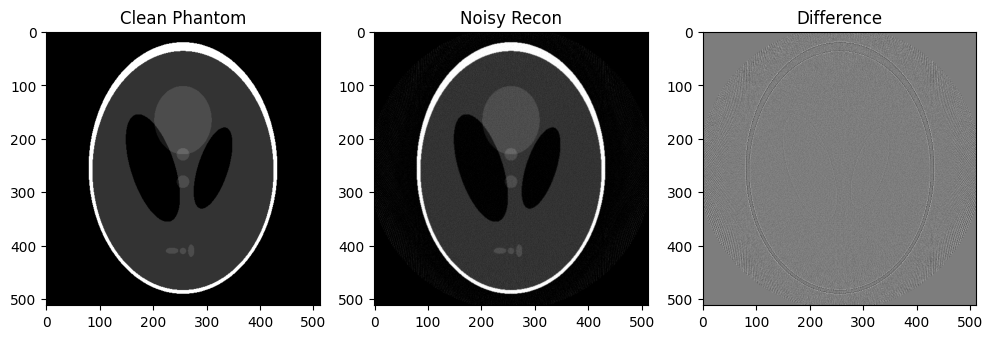

In [17]:
# Observe under same window.
noisyRec = imreadRaw('./tmp/rec/rec_noisy.raw', 512, 512, nSlice=1, dtype=np.float32).squeeze()
plt.figure(figsize=(12, 8))
l, r = np.min(phantom), np.max(phantom)
plt.subplot(131); plt.imshow(window(phantom, (l, r), style='lr', normalize='01'), cmap='gray', **VMIN0_VMAX1); plt.title('Clean Phantom')
plt.subplot(132); plt.imshow(window(noisyRec, (l, r), style='lr', normalize='01'), cmap='gray', **VMIN0_VMAX1); plt.title('Noisy Recon')
plt.subplot(133); plt.imshow(noisyRec - phantom, cmap='gray'); plt.title('Difference')
plt.show()

In [20]:
# Check if they are similar.
print('RMSE (%): {:.2f}'.format(computeRMSE(noisyRec, phantom)))

MAPE (%): 0.00
